# Adverserial Baysian Optimization

Joeri R. Hermans and Gilles Louppe

In [1]:
!date

Fri Oct 27 20:47:09 CEST 2017


## Introduction

In [40]:
import torch
import numpy as np
import math
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt

from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.utils import check_random_state

## Utility methods

In [37]:
def add_prior_beam_energy(prior):
    g = random_gaussian(mu=[30, 60], sigma=1.0)
    add_prior(prior, g['mu'], g['sigma'])


def add_prior_fermi_constant(prior):
    g = random_gaussian(mu=[0, 2], sigma=1.0)
    add_prior(prior, g['mu'], g['sigma'])


def add_prior(prior, mu, sigma):
    prior['mu'].append(mu)
    prior['sigma'].append(sigma)


def random_gaussian(mu=[-1, 1], sigma=5.0):
    return {'mu': np.random.uniform(mu[0], mu[1]),
            'sigma': np.random.uniform(0.0, sigma)}


def draw_gaussian(d, num_samples, random_state=None):
    num_parameters = len(d['mu'])
    thetas = torch.zeros((num_samples, num_parameters))
    mu = d['mu']
    sigma = d['sigma'].exp()
    for i in range(0, num_samples):
        gaussian = torch.normal(mu, sigma)
        thetas[i, :] = gaussian

    return thetas


def real_experiment(theta, n_samples=100000):
    return simulator(theta, n_samples)


def simulator(theta, n_samples, random_state=None):
    rng = check_random_state(random_state)
    samples = simulator_rej_sample_costheta(n_samples, theta, rng)

    return torch.from_numpy(samples.reshape(-1, 1)).float()


def simulator_rej_sample_costheta(n_samples, theta, rng):
    sqrtshalf = theta[0]
    gf = theta[1]

    ntrials = 0
    samples = []
    x = torch.linspace(-1, 1, steps=1000)
    maxval = torch.max(simulator_diffxsec(x, sqrtshalf, gf))

    while len(samples) < n_samples:
        ntrials = ntrials + 1
        xprop = rng.uniform(-1, 1)
        ycut = rng.rand()
        yprop = (simulator_diffxsec(xprop, sqrtshalf, gf) / maxval)[0]
        if (yprop / maxval) < ycut:
            continue
        samples.append(xprop)

    return np.array(samples)


def simulator_diffxsec(costheta, sqrtshalf, gf):
    norm = 2. * (1. + 1. / 3.)
    return ((1 + costheta ** 2) + simulator_a_fb(sqrtshalf, gf) * costheta) / norm


def simulator_a_fb(sqrtshalf, gf):
    mz = 90
    gf_nom = 0.9
    sqrts = sqrtshalf * 2.
    x = torch.FloatTensor([(sqrts - mz) / mz * 10])
    a_fb_en = torch.tanh(x)
    a_fb_gf = gf / gf_nom

    return 2 * a_fb_en * a_fb_gf


def plot_observations(X_observed, theta, normed=True):
    plt.grid(True)
    plt.hist(X_observed, histtype="bar", range=(-1, 1), bins=100, normed=normed)
    plt.xlim([-1, 1])
    if normed:
        plt.ylim([0, 2])
        plt.ylabel("Normalized Number of Events")
    else:
        plt.ylim([0, 3000])
        plt.ylabel("Number of Events")
    plt.title(r"Distribution of $\cos(A)$ in $e^-e^+ \rightarrow \mu^-\mu^+$ events." + "\n"
              r"$E_{beam}}$ = " + str(theta[0]) + "GeV   -   " + r"$G_f$ = " + str(theta[1]))
    plt.xlabel(r"$\cos(A)$")
    plt.show()

    
def sample_real_data(p_r, batch_size=256):
    samples = torch.zeros((batch_size, 1))
    num_samples_p_r = len(p_r)
    for index in range(0, batch_size):
        random_index = random.randint(0, num_samples_p_r - 1)
        samples[index, :] = p_r[random_index]

    return torch.autograd.Variable(samples)


def sample_generated_data(proposal, batch_size=256):
    # Sample `batch_size` thetas according to our proposal distribution.
    thetas = draw_gaussian(proposal, batch_size)
    # Obtain the individual Gaussians.
    theta_beam_energy = thetas[:, 0]
    theta_fermi_constant = thetas[:, 1]
    # Sample according to the proposal distribution.
    samples = torch.zeros((batch_size, 1))
    for sample_index, theta in enumerate(thetas):
        samples[sample_index, :] = simulator(theta, 1)

    return torch.autograd.Variable(samples)
    
    
def compute_gradient_penalty(critic, real, fake, l=5.0):
    # Compute x_hat and its output.
    epsilon = torch.rand(real.size())
    x_hat = epsilon * real + ((1. - epsilon) * fake)
    x_hat = torch.autograd.Variable(x_hat, requires_grad=True)
    y_hat = critic(x_hat)
    # Compute the associated gradients.
    gradients = torch.autograd.grad(outputs=y_hat, inputs=x_hat,
                                    grad_outputs=torch.ones(y_hat.size()),
                                    create_graph=True, retain_graph=True, only_inputs=True)[0]
    # Prevent norm 0 causing NaN.
    gradients = gradients + 1e-16
    # Compute the gradient penalty.
    gradient_penalty = l * ((gradients.norm(2, dim=1) - 1.) ** 2)

    return gradient_penalty
    

class Critic(torch.nn.Module):

    def __init__(self, num_hidden):
        super(Critic, self).__init__()
        self.fc_1 = torch.nn.Linear(1, num_hidden)
        self.fc_2 = torch.nn.Linear(num_hidden, num_hidden)
        self.fc_3 = torch.nn.Linear(num_hidden, 1)

    def forward(self, x):
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = (self.fc_3(x))

        return x


class CriticWithSigmoid(torch.nn.Module):

    def __init__(self, num_hidden):
        super(CriticWithSigmoid, self).__init__()
        self.fc_1 = torch.nn.Linear(1, num_hidden)
        self.fc_2 = torch.nn.Linear(num_hidden, num_hidden)
        self.fc_3 = torch.nn.Linear(num_hidden, 1)

    def forward(self, x):
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = F.sigmoid(self.fc_3(x))

        return x

## Simulator

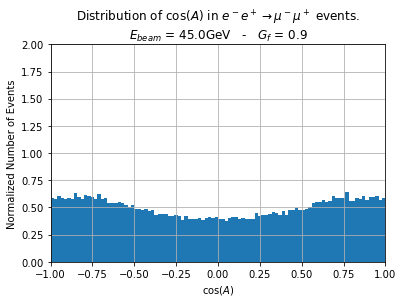

Total number of true experimental observations: 100000


In [25]:
# Define the true parameterization of theta.
theta_true = [45., .9]

# This parameterization will produce the following distribution in the real experiment.
real_data = real_experiment(theta_true).view(-1).numpy()
plot_observations(real_data, theta_true)

# Display the total number of observations available.
num_real_samples = len(real_data)
print("Total number of true experimental observations: " + str(num_real_samples))

## Objective

In order to find the parameterizations which fit the true experimental observation, we want to pick the parameterization of a theory which maximizes the loss of our critic after being optimally trained.

In [30]:
# Initialize the proposal distribution.
proposal = {
    'mu': [41., .7],   # Mean of the proposal distribution.
    'sigma': [1., 1.]  # Uncertainty of the proposal distribution.
}

In [42]:
fit(proposal, real_data)

RuntimeError: copy from numpy.float32 to torch.FloatTensor isn't implemented

In [ ]:
def fit(proposal, experiment_data, max_iterations=100, batch_size=256):
    # Define the critic network with 100 hidden neurons.
    critic = CriticWithSigmoid(100)
    # Define the global optimizer of the critic.
    critic_optimizer = torch.optim.Adam(critic.parameters(), lr=0.001)
    # Seed the gaussian process.
    # Apply the fitting process for a maximum number of 100 iterations.
    for iteration in range(0, max_iterations):
        # Fit the critic optimally.
        loss = fit_critic(proposal, experiment_data, critic, critic_optimizer, 10000, batch_size)
        # Add the loss to the Gaussian Process, and fit the proposal distribution optimally.
        fit_proposal(proposal)
        # Display the current proposal distribution.
        print("Current Proposal Distribution:")
        print("  mu: " + str(proposal['mu']))
        print("  sigma: " + str(proposal['sigma']))

        
def fit_proposal(proposal):
    pass
        
        
def fit_critic(proposal, p_r, critic, optimizer, num_critic_iterations=50000, batch_size=256):
     # Fetch the data batches.
    x_r = sample_real_data(p_r, batch_size)
    x_g = sample_generated_data(proposal, batch_size)
    # Fit the critic optimally.
    for iteration in range(0, num_critic_iterations):
        # Reset the gradients.
        critic.zero_grad()
        # Forward pass with real data.
        y_r = critic(x_r).mean()
        # Forward pass with generated data.
        y_g = critic(x_g).mean()
        # Obtain gradient penalty (GP).
        gp = compute_gradient_penalty(critic, x_r.data, x_g.data).mean()
        # Compute the loss, and the accompanying gradients.
        loss = y_g - y_r + gp
        loss.backward()
        optimizer.step()
    
    return loss.data.numpy()[0]